<a href="https://colab.research.google.com/github/GitData-GA/shot-marilyns-analysis/blob/main/code/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math
import pandas as pd
from glob import glob
import skimage.io as skio
from skimage.color import rgb2gray, rgba2rgb, hsv2rgb
from tqdm import notebook as tqdm
from skimage.transform import resize
import os
import gdown
from tqdm.notebook import tqdm
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import webcolors

In [2]:
newpath = r'img'
if not os.path.exists(newpath):
    os.makedirs(newpath)

# Improt images and data preparation

In [3]:
img_links = [
    "https://shotmarilyns.gd.edu.kg/assets/img/shot_orange_marilyn.jpg",
    "https://shotmarilyns.gd.edu.kg/assets/img/shot_red_marilyn.jpg",
    "https://shotmarilyns.gd.edu.kg/assets/img/shot_turq_marilyn.jpg",
    "https://shotmarilyns.gd.edu.kg/assets/img/shot_blue_marilyn.jpg",
    "https://shotmarilyns.gd.edu.kg/assets/img/shot_eggblue_marilyn.jpg"
]

img_names = [
    "orange_marilyn",
    "red_marilyn",
    "turq_marilyn",
    "blue_marilyn",
    "eggblue_marilyn"
]

# Save original images

In [4]:
idx = 1
for img_link, img_name in zip(img_links, img_names):
    response = requests.get(img_link)
    if response.status_code == 200:
        img_extension = img_link.split('.')[-1]
        save_path = os.path.join("img", f"1_{idx}_{img_name}.{img_extension}")
        with open(save_path, 'wb') as f:
            f.write(response.content)
        print(f"Saved {img_name} to {save_path}")
    else:
        print(f"Failed to download {img_name}")
    idx += 1

Saved orange_marilyn to img/1_1_orange_marilyn.jpg
Saved red_marilyn to img/1_2_red_marilyn.jpg
Saved turq_marilyn to img/1_3_turq_marilyn.jpg
Saved blue_marilyn to img/1_4_blue_marilyn.jpg
Saved eggblue_marilyn to img/1_5_eggblue_marilyn.jpg


## Store the images as a NumPy array

In [5]:
# Read:
# Takes in a list of file paths (URLs) to images.
#
# Modify:
# Reads each image from the provided file paths using skimage.io.imread.
# Appends each image (as a NumPy array) to a list.
#
# Export:
# Returns a NumPy array containing all the images.
def np_convert(filepaths):
  img_data = []
  for filepath in filepaths:
    img = skio.imread(filepath)
    img_data.append(img)
  return np.array(img_data)

np_img = np_convert(img_links)

## Store the images as a list of 5 Pandas dataframes with HEX codes

In [6]:
# Read:
# Takes in a NumPy array of images.
#
# Modify:
# For each image in the array: Reshapes the image to ensure it has an RGB
# structure (-1, 3). Converts each RGB triplet to a hex color code. Combines
# the RGB values and hex codes into a DataFrame with columns "r", "g", "b",
# and "hex". Ensures the RGB columns are of integer type. Appends the DataFrame
# to a list.
#
# Export:
# Returns a list of Pandas DataFrames, each containing RGB values and their
# corresponding hex codes.
def pd_convert(np_img):
  def rgb_to_hex_vectorized(rgb_array):
    def rgb_to_hex(rgb):
        return '#{:02x}{:02x}{:02x}'.format(*rgb)
    return np.apply_along_axis(rgb_to_hex, 1, rgb_array)
  img_data = []
  for img in np_img:
    rgb = img.reshape(-1, 3)
    hex = rgb_to_hex_vectorized(rgb).reshape(-1, 1)
    df = pd.DataFrame(np.hstack((rgb, hex)), columns=["Red", "Green", "Blue", "hex"])
    df[["Red", "Green", "Blue"]] = df[["Red", "Green", "Blue"]].astype(int)
    df[["hex"]] = df[["hex"]].astype(str)
    img_data.append(df)
  return img_data

pd_img = pd_convert(np_img)

## Show each image along with its dimension

orange_marilyn dimension: (960, 960, 3)


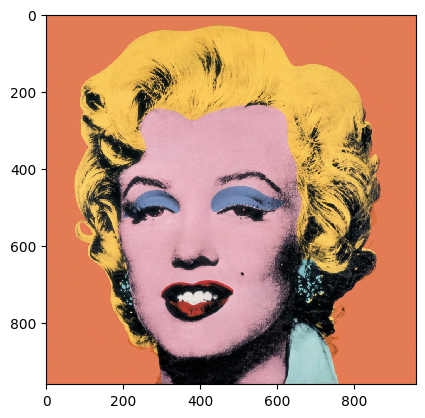




red_marilyn dimension: (960, 960, 3)


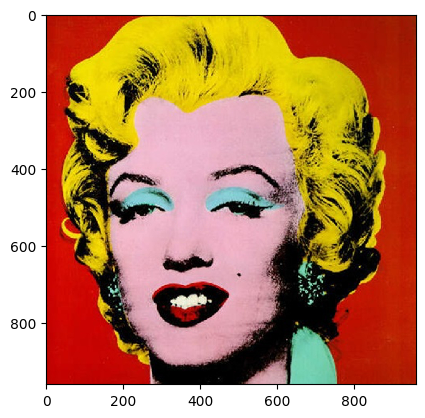




turq_marilyn dimension: (960, 960, 3)


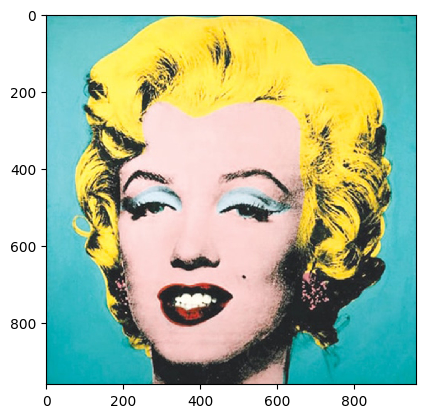




blue_marilyn dimension: (960, 960, 3)


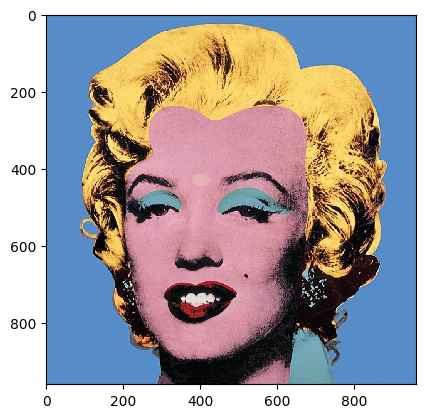




eggblue_marilyn dimension: (960, 960, 3)


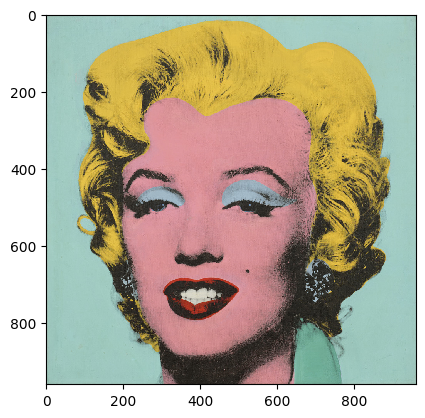

In [7]:
for i in range(0, np_img.shape[0]):
  print(f"{img_names[i]} dimension: {np_img[i].shape}")
  plt.imshow(np_img[i], interpolation='nearest')
  plt.show()
  print("\n\n")

# Distribution plots

orange_marilyn


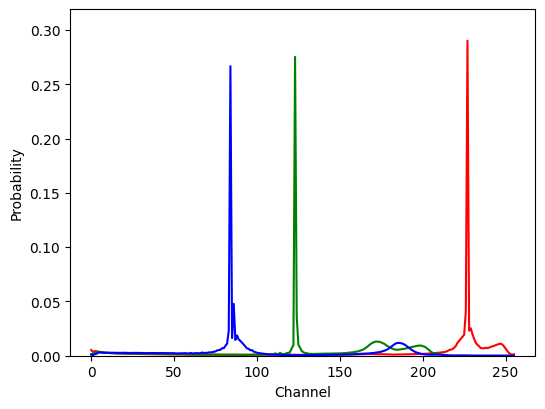




red_marilyn


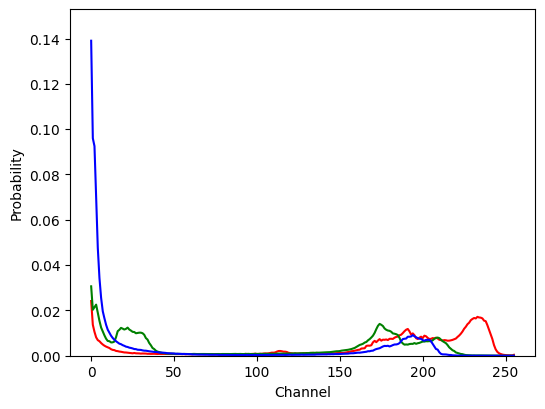




turq_marilyn


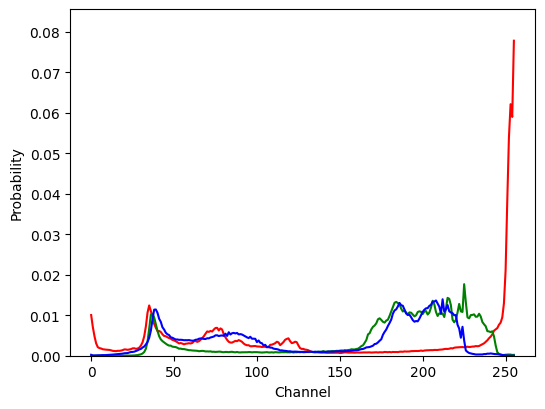




blue_marilyn


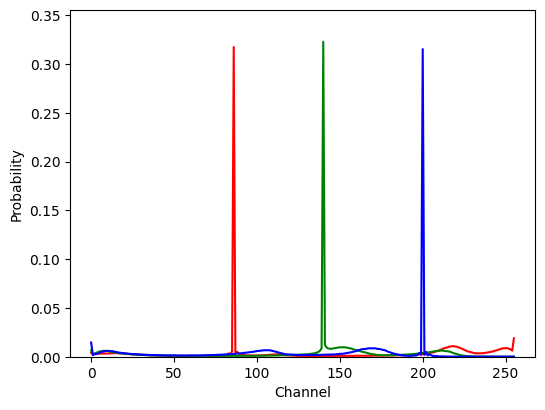




eggblue_marilyn


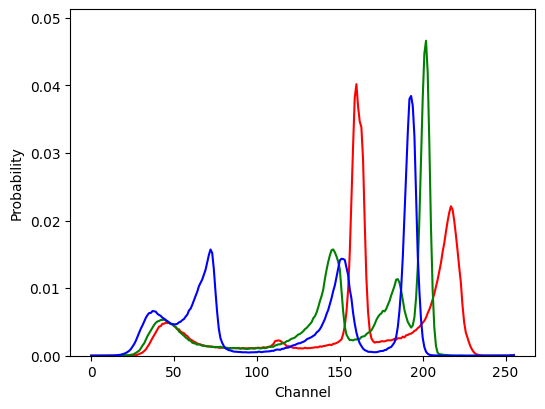

In [8]:
# Read:
# - np_img: A list or NumPy array containing the images to process.
# - width: (Optional) Width of the output plot figure (default: 5).
# - height: (Optional) Height of the output plot figure (default: 4.5).
# - ylim_lower: (Optional) Lower bound for the y-axis of the plot (default: 0).
# - ylim_upper: (Optional) Upper bound for the y-axis of the plot (default: 0.33).
# - show_plot: (Optional) Whether or not show the plot in console (default: False).
#
# Modify:
# This function iterates through each image in np_img. For each image, it
# separates the red, green, and blue channels. It calculates the histogram for
# each channel. It normalizes the histograms to obtain probabilities by dividing
# by the total number of pixels. It creates a plot with three lines representing
# the red, green, and blue channel probabilities. It sets the x and y labels,
# and adjusts the y-axis limits based on the provided arguments. Finally, it
# saves the plot as an SVG file with a unique filename based on the image index
# and name.
#
# Export:
# This function doesn't explicitly return a value. It creates and saves individual
# SVG files for the distribution plots of each image.
def distribution_plot(np_img, width=6, height=4.5, show_plot=False):
  idx = 0
  for img in np_img:
    red_channel = img[:,:,0]
    green_channel = img[:,:,1]
    blue_channel = img[:,:,2]

    red_hist = np.histogram(red_channel, bins=256, range=(0, 256))[0]
    green_hist = np.histogram(green_channel, bins=256, range=(0, 256))[0]
    blue_hist = np.histogram(blue_channel, bins=256, range=(0, 256))[0]

    # Normalize the histograms to obtain probabilities
    total_pixels = img.shape[0] * img.shape[1]
    red_prob = red_hist / total_pixels
    green_prob = green_hist / total_pixels
    blue_prob = blue_hist / total_pixels
    ylim_upper = max(max(red_prob), max(green_prob), max(blue_prob))

    plt.figure(figsize=(width, height))
    plt.plot(red_prob, color='red')
    plt.plot(green_prob, color='green')
    plt.plot(blue_prob, color='blue')
    plt.xlabel('Channel')
    plt.ylabel('Probability')
    plt.ylim(0, 1.1 * ylim_upper)

    # Save the plot as an SVG file
    plt.savefig(f"img/2_{idx + 1}_{img_names[idx]}_dist.svg",
                format='svg', dpi=512, bbox_inches='tight')
    if (show_plot):
      print(f"{img_names[idx]}")
      plt.show()
      print("\n\n")
    plt.close()
    idx += 1

distribution_plot(np_img, show_plot=True)

# Relative conditional entropy plots

## Entropy calculation

In [9]:
# Read:
# - Y: A NumPy array.
#
# Modify:
# This function calculates the Shannon entropy of the input array Y. It uses
# np.unique to find the unique elements and their counts in Y. It calculates
# the probability of each unique element by dividing the count by the total
# number of elements. It calculates the entropy using the formula -sum(p * log2(p)),
# where p is the probability of each element.
#
# Export:
# Returns the calculated Shannon entropy as a scalar value.
def shanon_entropy(Y):
  unique, count = np.unique(Y, return_counts=True, axis=0)
  prob = count/len(Y)
  entropy = np.sum((-1)*prob*np.log2(prob))
  return entropy

# Read:
# - Y: A NumPy array.
# - X: A NumPy array.
#
# Modify:
# This function calculates the joint entropy of two input arrays Y and X. It
# concatenates Y and X along columns using np.c_ to create a new array YX. It
# calls the shanon_entropy function to calculate the entropy of the combined
# array YX.
#
# Export:
# Returns the joint entropy of Y and X as a scalar value.
def joiny_entropy(Y,X):
  YX = np.c_[Y,X]
  return shanon_entropy(YX)

# Read:
# - Y: A NumPy array.
# - X: A NumPy array.
#
# Modify:
# This function calculates the conditional entropy of Y given X. It calls the
# joiny_entropy function to calculate the joint entropy of Y and X. It calls
# the shanon_entropy function to calculate the entropy of X. It subtracts the
# entropy of X from the joint entropy of Y and X to get the conditional entropy.
#
# Export:
# Returns the conditional entropy of Y given X as a scalar value.
def conditional_entropy(Y, X):
  return joiny_entropy(Y, X) - shanon_entropy(X)

# Read:
# - Y: A NumPy array.
# - X: A NumPy array.
#
# Modify:
# This function calculates the relative conditional entropy of Y given X. It
# calls the conditional_entropy function to calculate the conditional entropy of
# Y given X. It calls the shanon_entropy function to calculate the entropy of Y.
# It divides the conditional entropy by the entropy of Y to get the relative
# conditional entropy.
#
# Export:
# Returns the relative conditional entropy of Y given X as a scalar value.
def relative_conditional_entropy(Y, X):
  return conditional_entropy(Y, X) / shanon_entropy(Y)

## Generating plots

orange_marilyn


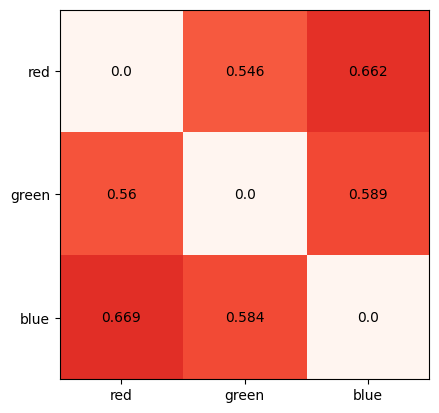




red_marilyn


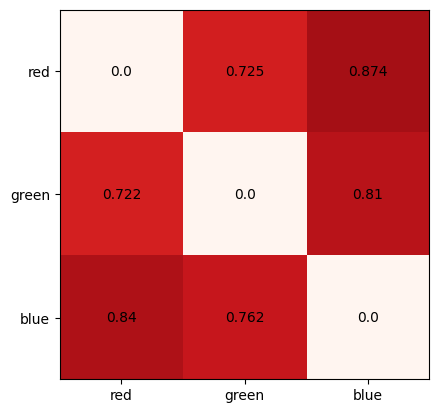




turq_marilyn


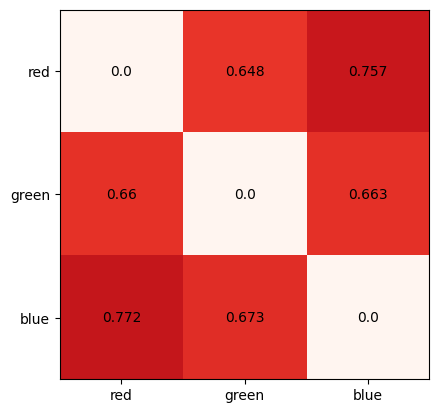




blue_marilyn


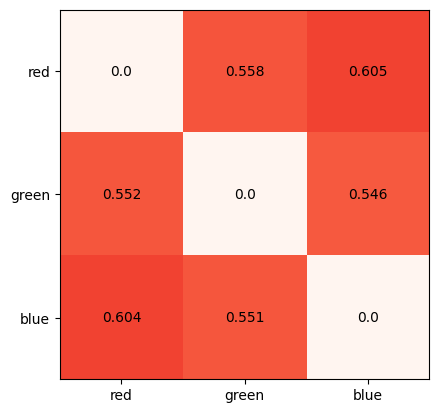




eggblue_marilyn


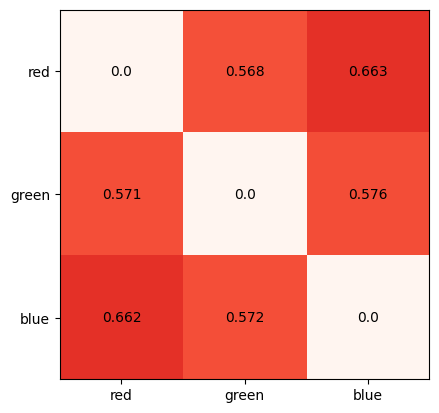

In [10]:
# Read:
# - np_img: A NumPy array containing multiple images.
# - show_plot: (Optional) Whether or not show the plot in console (default: False).
#
# Modify:
# This function calculates the relative conditional entropy between the red,
# green, and blue channels of each image in np_img. For each image, it extracts
# the red, green, and blue channels, reshapes them appropriately, and calculates
# the relative conditional entropy between each pair of channels using the
# relative_conditional_entropy function. The results are stored in a 3x3 matrix,
# which is used to create a heatmap plot. The heatmap is saved as an SVG file
# with a filename based on the image index and a predefined name.
#
# Export:
# Saves the heatmap plot of the relative conditional entropy values as an SVG
# file for each image in np_img.
def relative_conditional_entropy_plot(np_img, show_plot=False):
  idx = 0
  for img in np_img:
    # Extract channel and flattern to correct format
    red = np.hstack(
        (
            img[:,:,0].reshape(-1, 1),
            np.zeros((img[:,:,0].reshape(-1, 1).shape[0], 1)),
            np.zeros((img[:,:,0].reshape(-1, 1).shape[0], 1))
            )
        )
    green = np.hstack(
        (
            np.zeros((img[:,:,1].reshape(-1, 1).shape[0], 1)),
            img[:,:,1].reshape(-1, 1),
            np.zeros((img[:,:,1].reshape(-1, 1).shape[0], 1))
            )
        )
    blue = np.hstack(
        (
            np.zeros((img[:,:,2].reshape(-1, 1).shape[0], 1)),
            np.zeros((img[:,:,2].reshape(-1, 1).shape[0], 1)),
            img[:,:,2].reshape(-1, 1)
            )
        )

    # Calculate relative conditional entropy
    red_blue = relative_conditional_entropy(red, blue)
    red_green = relative_conditional_entropy(red, green)
    red_red = relative_conditional_entropy(red, red)
    blue_red = relative_conditional_entropy(blue, red)
    blue_green = relative_conditional_entropy(blue, green)
    blue_blue = relative_conditional_entropy(blue, blue)
    green_blue = relative_conditional_entropy(green, blue)
    green_red = relative_conditional_entropy(green, red)
    green_green = relative_conditional_entropy(green, green)

    # Probability values for each cell
    probabilities = np.array([[red_red, round(red_green, 3), round(red_blue, 3)],
                              [round(green_red, 3), green_green, round(green_blue, 3)],
                              [round(blue_red, 3), round(blue_green, 3), blue_blue]])

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Create the heatmap
    heatmap = ax.imshow(probabilities, cmap='Reds', vmin=0, vmax=1)

    # Set the colorbar
    # plt.colorbar(heatmap)

    # Set the tick labels
    ax.set_xticks(np.arange(3))
    ax.set_yticks(np.arange(3))
    ax.set_xticklabels(['red', 'green', 'blue'])
    ax.set_yticklabels(['red', 'green', 'blue'])

    # Loop over the data and create text annotations for each cell
    for i in range(3):
        for j in range(3):
            text = ax.text(j, i, probabilities[i, j],
                           ha='center', va='center', color='black')

    # Save the plot as an SVG file
    plt.savefig(f"img/3_{idx + 1}_{img_names[idx]}_relative_conditional_entropy.svg",
                format='svg', dpi=512, bbox_inches='tight')
    if (show_plot):
      print(f"{img_names[idx]}")
      plt.show()
      print("\n\n")
    plt.close()
    idx += 1

relative_conditional_entropy_plot(np_img, show_plot=True)

# RGB space scatterplots

orange_marilyn color Red Green


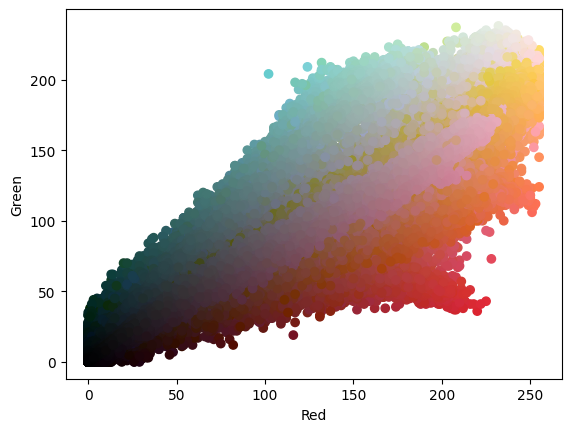




orange_marilyn color Red Blue


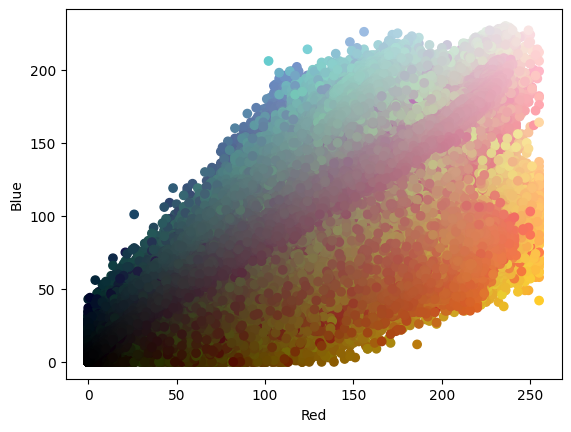




orange_marilyn color Green Blue


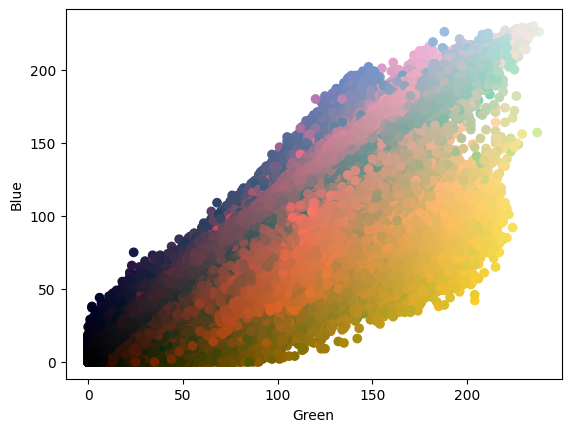




orange_marilyn grey Red Green Blue


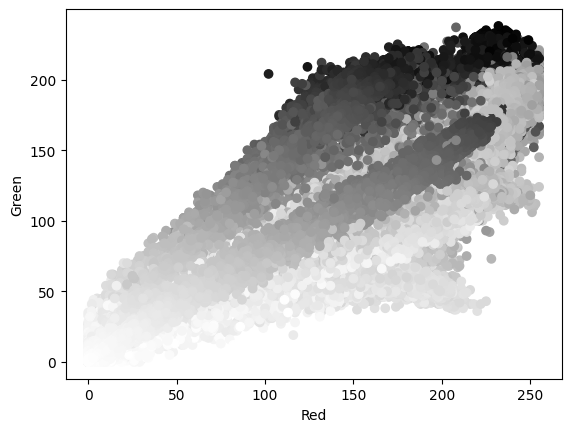




orange_marilyn grey Red Blue Green


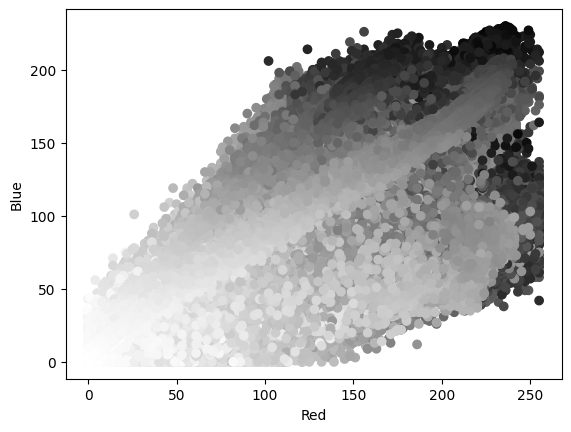




orange_marilyn grey Green Blue Red


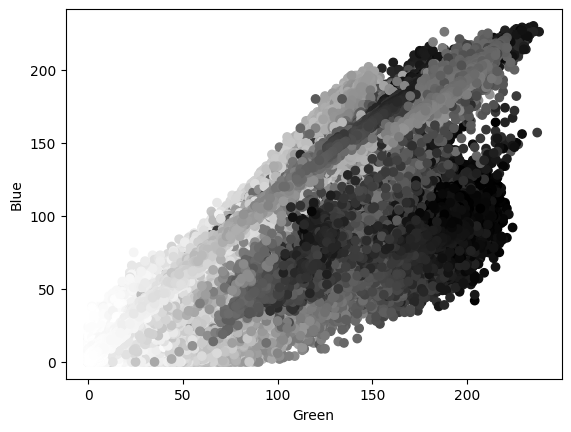




red_marilyn color Red Green


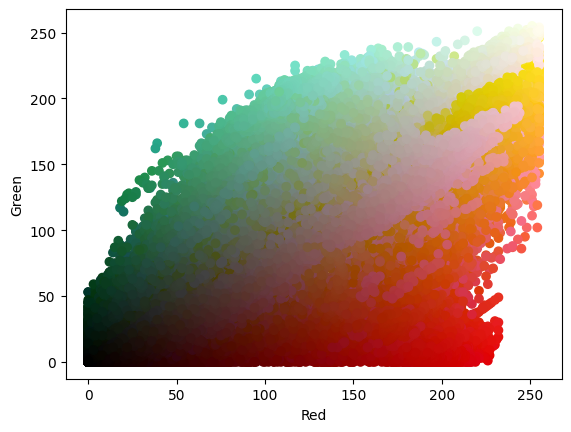




red_marilyn color Red Blue


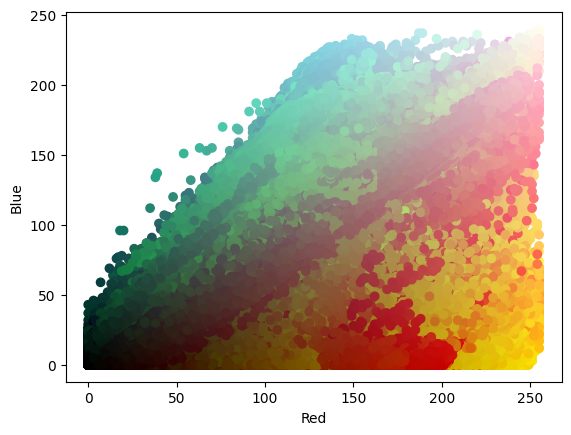




red_marilyn color Green Blue


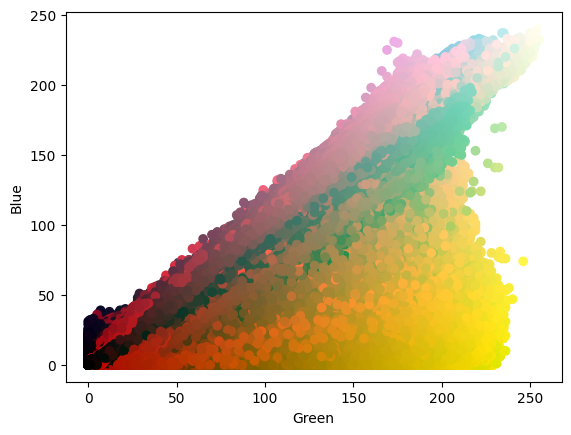




red_marilyn grey Red Green Blue


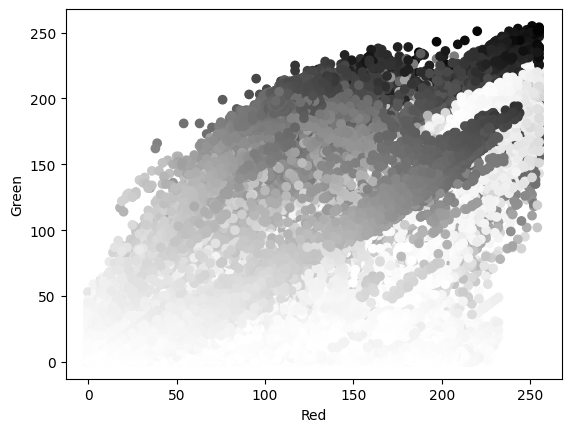




red_marilyn grey Red Blue Green


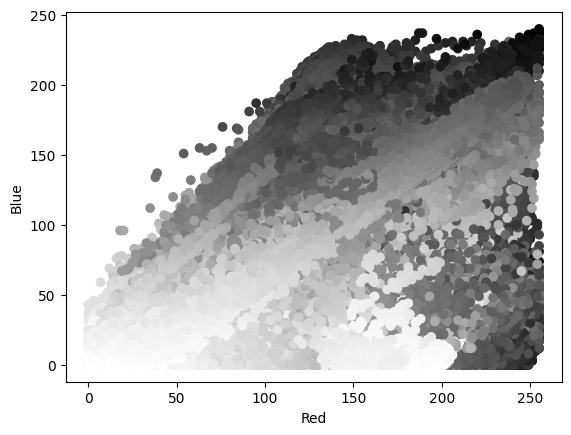




red_marilyn grey Green Blue Red


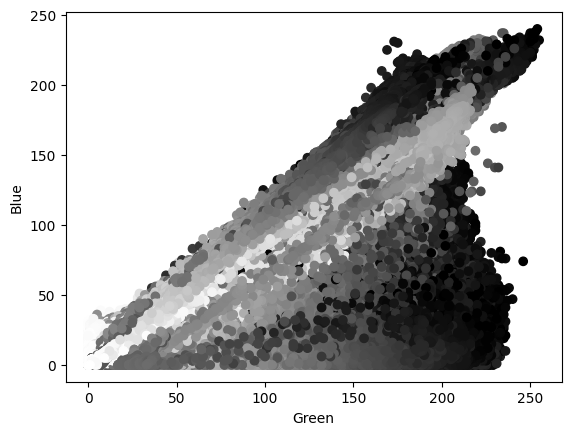




turq_marilyn color Red Green


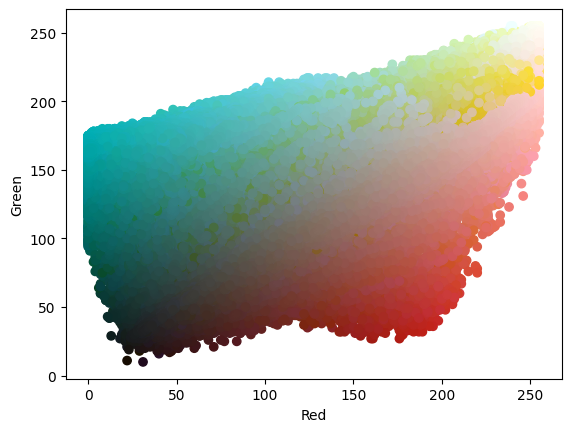




turq_marilyn color Red Blue


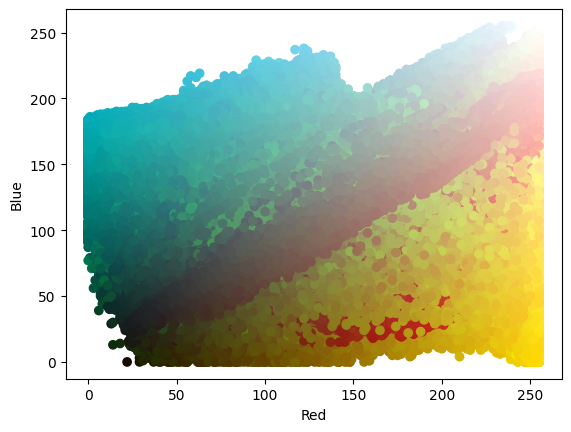




turq_marilyn color Green Blue


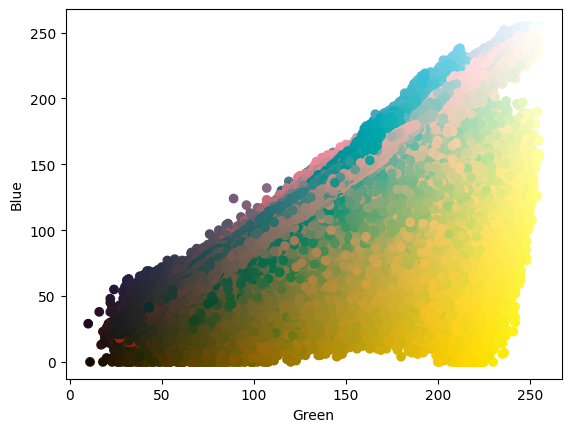




turq_marilyn grey Red Green Blue


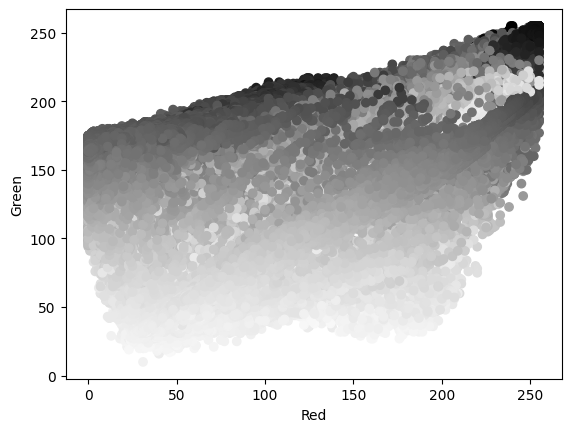




turq_marilyn grey Red Blue Green


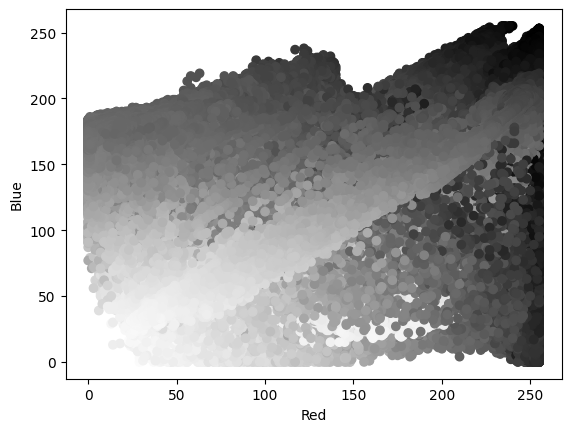




turq_marilyn grey Green Blue Red


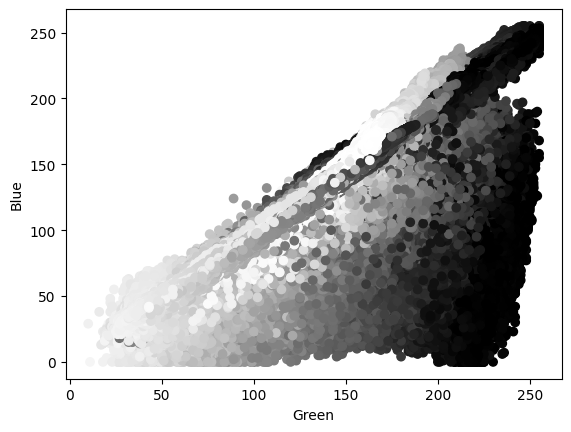




blue_marilyn color Red Green


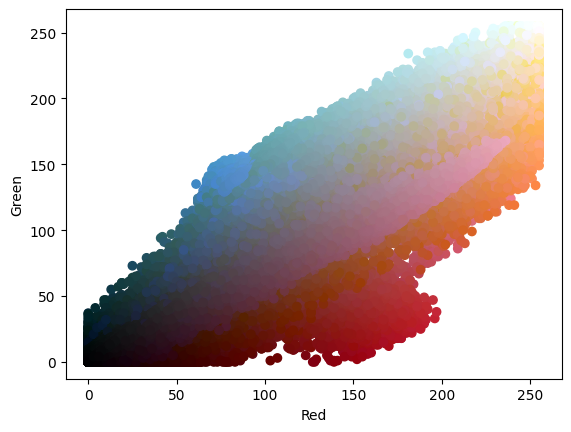




blue_marilyn color Red Blue


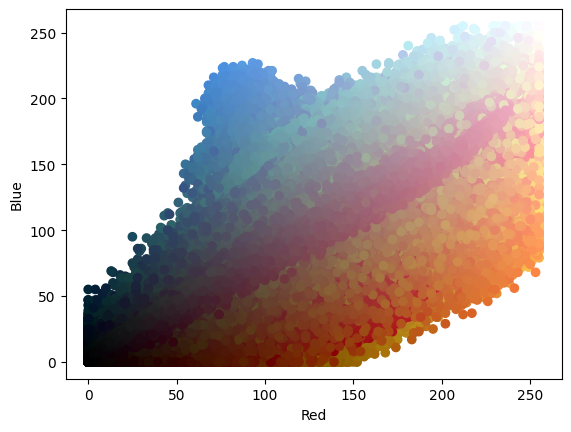




blue_marilyn color Green Blue


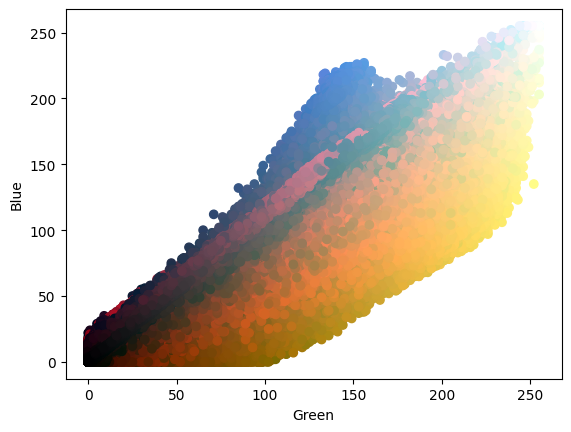




blue_marilyn grey Red Green Blue


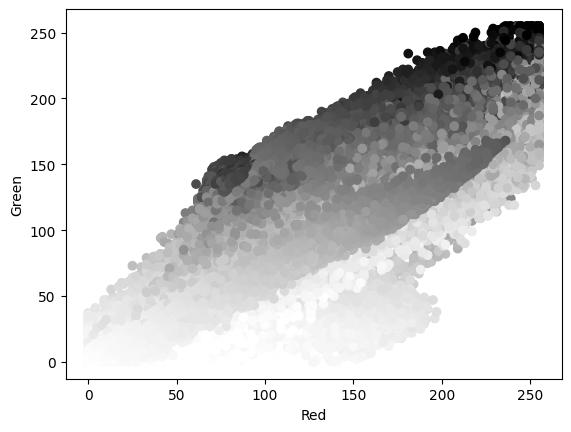




blue_marilyn grey Red Blue Green


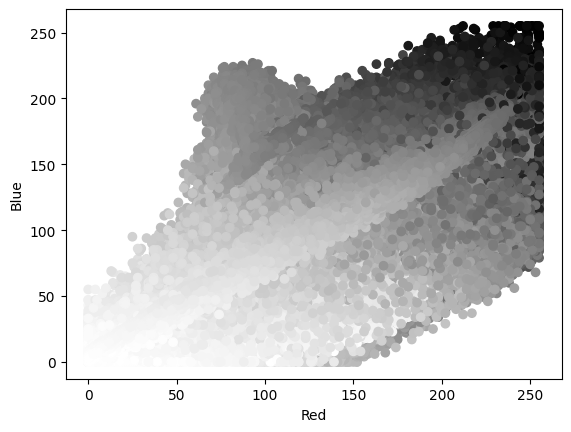




blue_marilyn grey Green Blue Red


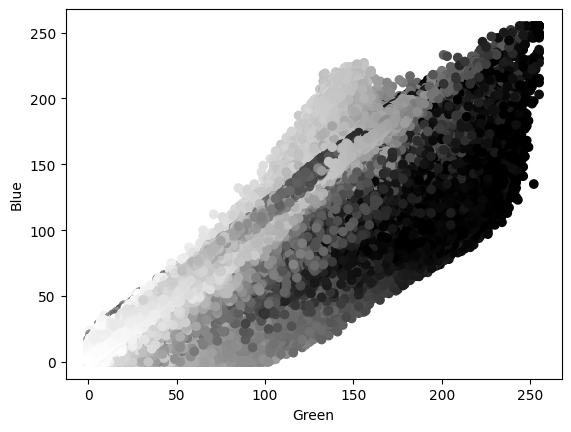




eggblue_marilyn color Red Green


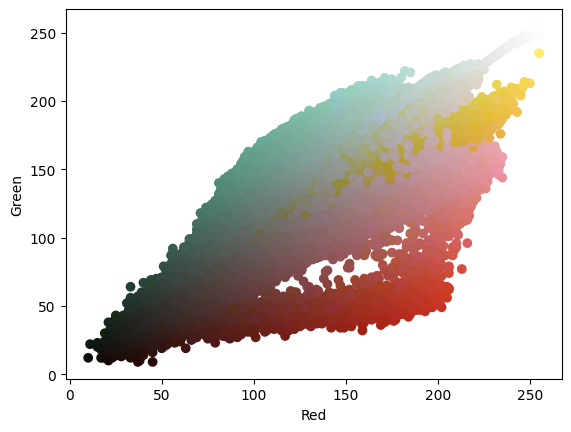




eggblue_marilyn color Red Blue


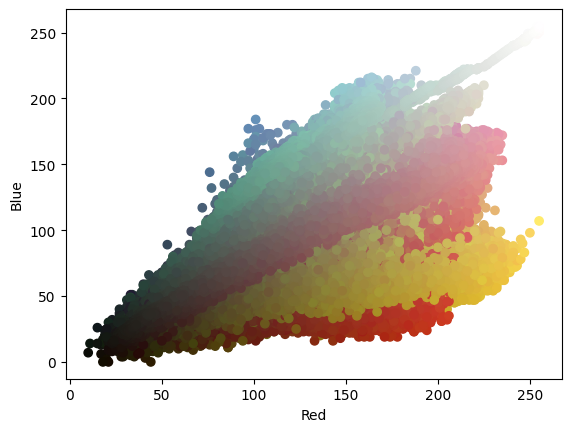




eggblue_marilyn color Green Blue


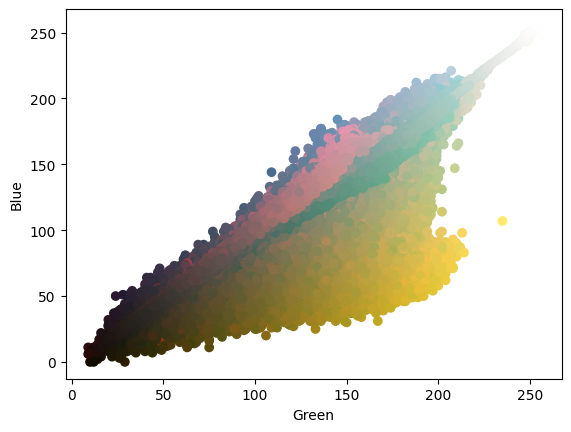




eggblue_marilyn grey Red Green Blue


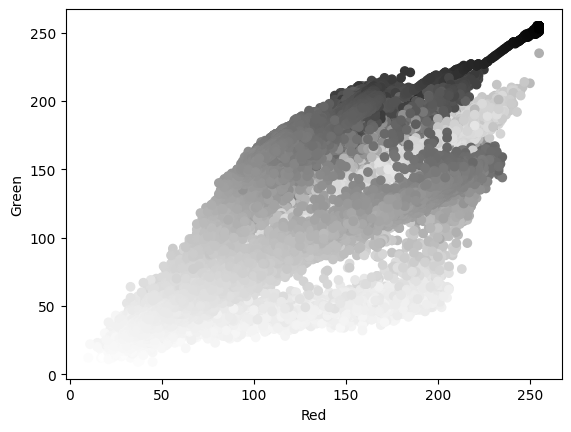




eggblue_marilyn grey Red Blue Green


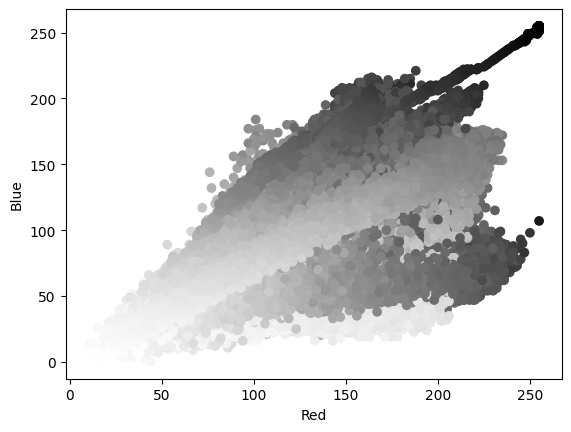




eggblue_marilyn grey Green Blue Red


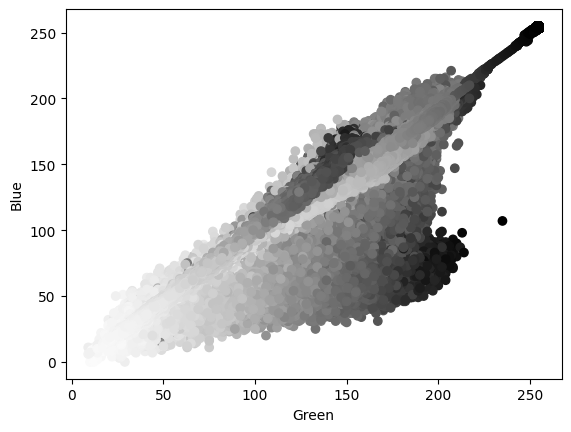

In [11]:
# Read:
# - pd_img: A Pandas DataFrame containing multiple images, each represented by
# data points for the red, green, and blue color channels along with hexadecimal
# color codes.
# - show_plot: (Optional) Indicates whether to display each plot in the console
# (default: False).
#
# Modify:
# This function generates RGB space scatter plots for each image in `pd_img`.
# For each image, it extracts the red, green, and blue channels along with
# their corresponding hexadecimal color codes. It creates scatter plots for
# three pairs of channels (`Red` vs `Green`, `Red` vs `Blue`, `Green` vs `Blue`)
# using two different colormaps (`viridis` and `Greys`). Each plot is saved as
# an JPG file named based on the image index and a predefined name.
#
# Export:
# Saves RGB space scatter plots as JPG files for each image in `pd_img`.
def rgb_space_scatterplots(pd_img, show_plot=False):
  idx = 0
  img_name_idx = 0
  for img in pd_img:
    # Plot with colors
    for xylabel in [['Red', 'Green'], ['Red', 'Blue'], ['Green', 'Blue']]:
      plt.xlabel(xylabel[0])
      plt.ylabel(xylabel[1])
      plt.scatter(img[xylabel[0]], img[xylabel[1]], c=img['hex'])

      # Save the plot as an SVG file
      plt.savefig(f"img/4_{idx + 1}_{img_names[img_name_idx]}_rgb_color_scatterplot.jpg",
                  format='jpg', dpi=512, bbox_inches='tight')

      if (show_plot):
        print(f"{img_names[img_name_idx]} color {xylabel[0]} {xylabel[1]}")
        plt.show()
        print("\n\n")
      plt.close()
      idx += 1

    # Plot without colors
    for xylabel in [['Red', 'Green', 'Blue'], ['Red', 'Blue', 'Green'], ['Green', 'Blue', 'Red']]:
      plt.xlabel(xylabel[0])
      plt.ylabel(xylabel[1])
      plt.scatter(img[xylabel[0]], img[xylabel[1]], c=img[xylabel[2]], cmap='Greys')

      # Save the plot as an SVG file
      plt.savefig(f"img/4_{idx + 1}_{img_names[img_name_idx]}_rgb_grey_scatterplot.jpg",
                  format='jpg', dpi=512, bbox_inches='tight')

      if (show_plot):
        print(f"{img_names[img_name_idx]} grey {xylabel[0]} {xylabel[1]} {xylabel[2]}")
        plt.show()
        print("\n\n")
      plt.close()
      idx += 1

    img_name_idx += 1

rgb_space_scatterplots(pd_img, show_plot=True)